# Prep Bringing in Data and Libraries 

This allows you to reload the data and make edits to the source code and then allowing you to actually be able to have the data be updated in this note book and is very handy

2nd line allows usd to be able to see plots in the jupyter notebook

In [1]:
%load_ext autoreload 
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
PATH = "data/bulldozers/"

In [ ]:
#grabbing the train set
#low_memory ->
#parse_dates is a tool set in pandas that allow you to bring in dates properly 
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory = False, parse_dates = ["saledate"])

In any sort of data science work, it's important to look at your data, to make sure you understand the format, how it's stored, what type of values it holds, etc. Even if you've read descriptions about your data, the actual data may not be what you expect.

In [ ]:
#this is another head() expect this will show us what we want and here it is 1000x10000
def display_all(df): 
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

In [ ]:
#using function 
display_all(df_raw)

In [ ]:
#This is allowing flip it to look at it differently and we want to just want to make sure that we actually got the data imported
#correctly. 
display_all(df_raw.tail().transpose())

# Kaggle Competiton look at what their metric is this will determine the dependent variable (EXTREMELY IMPORTANT)

It's important to note what metric is being used for a project. Generally, selecting the metric(s) is an important part of the project setup. However, in this case Kaggle tells us what metric to use: RMSLE (root mean squared log error) between the actual and predicted auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need.

In [ ]:
#Changing the dependent variable to log scale because we are interested in % wrong
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [ ]:
#n_jobs : integer, optional (default=1)
#The number of jobs to run in parallel for both `fit` and `predict`.
#If -1, then the number of jobs is set to the number of cores.
m = RandomForestRegressor(n_jobs=-1)

This dataset contains a mix of continuous and categorical variables.

The following method extracts particular date fields from a complete datetime for the purpose of constructing categoricals. You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities.

#This is the function that is datepart
#google getattr -> advance function
fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [ ]:
#First we know we have date and this feature can have some much value 
#saledate = datetime 64bit and we know that this can have DOW, Holiday, Sport Event, Begining of quarter,begining,end
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call train_cats to convert strings to pandas categories.

**train_cats Change any columns of strings in a panda's dataframe to a column of
    catagorical values. This applies the changes inplace.
    
**apply_cats -> apply_cats(df, trn)

In [ ]:
train_cats(df_raw)

In [ ]:
df_raw.UsageBand.head()

In [ ]:
#We will be interested in some of the cats to be ordered
df_raw.UsageBand.cat.categories

In [ ]:
#changing the order #Inplace will just get rid of the old and make one if false it will have the new and old
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

### Missing Data & Incorrect Data Will Always be a problem 

In [ ]:
#Missing data can't be directly passed to RDF's
#look if it's missing(sum it and sort by index (sort of grouping)/ the total number of observations)
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

But let's save this file for now, since it's already in format can we be stored and accessed efficiently.

In [ ]:
#Brand New Something Hardly anyone knows about (cutting-edge and becoming the standard)
#This is because we don't want to wait and this allows you to come back to where you were working 
os.makedirs('tmp', exist_ok = True)
df_raw.to_feather('tmp/bulldozers-raw')

# Pre-Process

In [ ]:
#Reading in the feather much faster


In [ ]:
#We'll replace categories with their numeric codes, handle missing continuous values, 
#and split the dependent variable into a separate variable.
df, y , nas= proc_df(df_raw, 'SalePrice', nas) #i don't know what the nas is a dictionary the values of the specifice medians 
#This
df.columns

We now have what we need to run an rdf this isn't going to be the best **Starting Point**

In [ ]:
m = RandomForestRegressor(n_jobs = -1)
#df is data frame with out sales price and y is the dependent variable 'SalesPrice'
m.fit(df, y) 
m.score(df, y)

In [ ]:
#This is creating a data partition 

def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid #401,125 - 12000 = 389,125
raw_train, raw_valid = split_vals(df_raw, n_trn) #create raw_train all variables, ntrn raw_val
X_train, X_valid = split_vals(df, n_trn) #create X_train(or all the variables to explain y from df(done above))
y_train, y_valid = split_vals(y, n_trn) # y or DV in an array created with proc_df(df_raw, 'SalePrice')

X_train.shape, y_train.shape, X_valid.shape

# Random Forest (Base Model)
*Let's train the model*

In [66]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [mean_absolute_error(m.predict(X_train), y_train), mean_absolute_error(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)     

In [64]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error()

<function sklearn.metrics.regression.mean_absolute_error>

In [68]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 29.2 s
[0.06021589599506387, 0.18495765776075374, 0.9828731064639216, 0.8887142120877399]


# Speeding things up

In [32]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [33]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 1.82 s
[0.11150884961381026, 0.35570260731152104, 0.9727679164380407, 0.7740449400662048]


# Single tree

In [35]:
#Tree with 3 depth 
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5255484017047328, 0.5799253837685487, 0.3950943520325594, 0.3993904808639117]


In [36]:
#Tree with no limit and grow to the very end and will over fit with reasonable understanding
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[6.2803698347351e-17, 0.4685631789072071, 1.0, 0.6079113336129829]


In [62]:
df_raw.fiProductClassDesc.cat.categories

Index(['Backhoe Loader - 0.0 to 14.0 Ft Standard Digging Depth',
       'Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth',
       'Backhoe Loader - 15.0 to 16.0 Ft Standard Digging Depth',
       'Backhoe Loader - 16.0 + Ft Standard Digging Depth',
       'Backhoe Loader - Unidentified',
       'Hydraulic Excavator, Track - 0.0 to 2.0 Metric Tons',
       'Hydraulic Excavator, Track - 11.0 to 12.0 Metric Tons',
       'Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons',
       'Hydraulic Excavator, Track - 14.0 to 16.0 Metric Tons',
       'Hydraulic Excavator, Track - 150.0 to 300.0 Metric Tons',
       'Hydraulic Excavator, Track - 16.0 to 19.0 Metric Tons',
       'Hydraulic Excavator, Track - 19.0 to 21.0 Metric Tons',
       'Hydraulic Excavator, Track - 2.0 to 3.0 Metric Tons',
       'Hydraulic Excavator, Track - 21.0 to 24.0 Metric Tons',
       'Hydraulic Excavator, Track - 24.0 to 28.0 Metric Tons',
       'Hydraulic Excavator, Track - 28.0 to 33.0 Metric Tons',
 

# Bagging 

Starting with the **Basic** Model

In [37]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 1.9 s
[0.11251907080783431, 0.3640139134930935, 0.9722722599181542, 0.7633622967608276]


In [38]:
#default is 10 trees NOTE THIS IS ON 20,000 not full dataset
#estimators is 10 because of the default so 20,0000 predictions 10 times
preds = np.stack([t.predict(X_valid) for t in m.estimators_])

#These trees are going to show that the prediction of the 10 trees on the first observation, then mean, 
#then the validation prediction on validation set
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([ 9.39266,  9.32812,  9.15905,  9.04782, 10.1849 ,  9.43348,  9.25913,  9.07681,  9.25913,  9.04782]),
 9.318892928585575,
 9.104979856318357)

In [ ]:
preds.shape

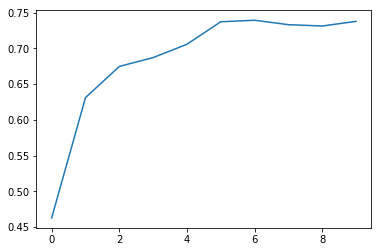

In [75]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis = 0)) for i in range(10)]);

In [ ]:
#Changing to more trees if it was more smooth we might expect not change, but it's looking to improve
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

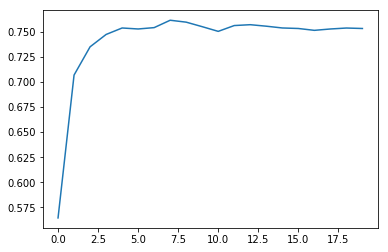

In [79]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis = 0)) for i in range(20)]);

see it begins to smooth we should still go up a little for a little improvement, but not much

In [ ]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

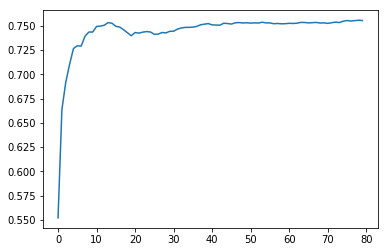

In [82]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis = 0)) for i in range(80)]);

# Out-of-bag (OOB) score
Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, random forests have a very clever trick called out-of-bag (OOB) error which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was not included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

This is as simple as adding one more parameter to our model constructor. We print the OOB error last in our print_score function below.

In [39]:
#oob r^2 will slightly underestimate 
#handy for hyperparameters (Grid Search)
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09633101871417454, 0.34081729346891987, 0.9796766869773679, 0.7925606129385327, 0.8530219592419025]


# Reducing Over-Fitting

It turns out that one of the easiest ways to avoid over-fitting is alsoone of the best ways to speed up analysis: *subsampling. 

In [90]:
df_trn.shape #understand made this earlier with a way to try to seed up analysis

(30000, 66)

In [41]:
df_trn, y_trn, nas= proc_df(df_raw, 'SalePrice', na_dict=nas)
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [43]:
#take random samples of subsets of the data we tell our model to take 20,000 or x amount of the df
#currently obbs score is not accurate see lesson 2 time 1hr 19mins
#WE are using this to understand what is actually tuningthe model and we don't need to run all of them 
set_rf_samples(20000)

In [44]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.22700966477944895, 0.26402568049697966, 0.8922980613238467, 0.8755083235716878, 0.8807657123805731]


# Tree Building Parameters

We revert tousing a full bootstrap sample inordertoshowtheimpactof other over-fitting avoidance methods

In [45]:
#Turn off the samples size
reset_rf_samples()

In [48]:
#oobs score is better because we are predicting
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07840083453991088, 0.23878688310519075, 0.9871537550968622, 0.8981716029221802, 0.9082700087341831]


Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with min_samples_leaf) that we require some minimum number of rows in every leaf node. This has two benefits:

 - There are less decision rules for each leaf node; simpler models should generalize better
 - The predictions are made by averaging more rows in the leaf node, resulting in less volatility
 - Good sample_leaf sizes to try 1,3,5,10,25

In [49]:
#First Tune is the basket or min_sample_leaf meaning we stop growing the free to have >=3 observations in each node

m = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf= 3, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1149551194468982, 0.23377112954343782, 0.9723820486553181, 0.9024045154661893, 0.9086476474643155]


Another Change Max_Features 

- Less corelated trees are the better (Imagen if one column was very good at describing the relationship)
    - If every tree used the same one to start the split at then we would miss the interaction between variables
    - Variation of the tree at every single split point we take random samples of columns (This is column sampling)
    - We are not longer looking at every single option, but rather a subset of the columns
        - Options used in this feature are defalut = None, other good ideas are .05 or the 'sqrt' or log2

In [59]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11932743272038504, 0.228340356590737, 0.9702411996187932, 0.9068863558317175, 0.9114660857877133]


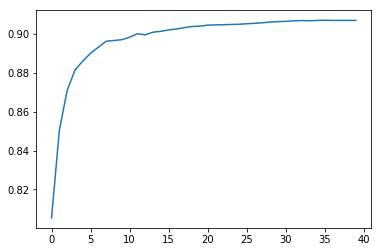

In [60]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
#this is taking all the rows and column 1 because the above creates an array
preds[:, 0], np.mean(preds[:,0]), y_valid[0]
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis = 0)) for i in range (40)]);